In [ ]:
%matplotlib inline


import copy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

# Multilayer perceptron

1. Напишите многослойный перцептрон для решения задачи из ([соревнования](https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i/overview))

2. Подберите метод градиентного спуска из списка SGD, Adam, Momentum (на отложенной выборке) и шаг для этого метода.

3. Подберите значение дропаута и коэффициент L2 регуляризации.

4. Постройте кривые обучения.

### Обработка данных

In [ ]:
import datetime
from datetime import datetime
from datetime import date
import torch

In [ ]:
train = pd.read_csv('/content/train.csv', nrows=100000)
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [ ]:
train.shape

(100000, 9)

In [ ]:
train.isnull().sum()

TRIP_ID             0
CALL_TYPE           0
ORIGIN_CALL     79038
ORIGIN_STAND    50689
TAXI_ID             0
TIMESTAMP           0
DAY_TYPE            0
MISSING_DATA        0
POLYLINE            0
dtype: int64

In [ ]:
train.dtypes

TRIP_ID           int64
CALL_TYPE        object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID           int64
TIMESTAMP         int64
DAY_TYPE         object
MISSING_DATA       bool
POLYLINE         object
dtype: object

In [ ]:
train.nunique()

TRIP_ID         99992
CALL_TYPE           3
ORIGIN_CALL      8160
ORIGIN_STAND       62
TAXI_ID           430
TIMESTAMP       96801
DAY_TYPE            1
MISSING_DATA        1
POLYLINE        99577
dtype: int64

In [ ]:
type(train['TIMESTAMP'][0])

numpy.int64

In [ ]:
# преобразуем столбец TIMESTAMP в 2 признака: день недели и час

train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP'], unit='s')
train['WEEKDAY'] = train['TIMESTAMP'].dt.weekday + 1
train['HOUR'] = train['TIMESTAMP'].dt.hour + 1

test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP'], unit='s')
test['WEEKDAY'] = test['TIMESTAMP'].dt.weekday + 1
test['HOUR'] = test['TIMESTAMP'].dt.hour + 1

In [ ]:
# удалим ненужные признаки

train = train.drop(['TRIP_ID', 'ORIGIN_CALL', 'DAY_TYPE', 'MISSING_DATA', 'TIMESTAMP'], axis=1)
test = test.drop(['TRIP_ID', 'ORIGIN_CALL', 'DAY_TYPE', 'MISSING_DATA', 'TIMESTAMP'], axis=1)

In [ ]:
train.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,POLYLINE,WEEKDAY,HOUR
0,C,NaN,20000589,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",1,1
1,B,7.0,20000596,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,1
2,C,NaN,20000320,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",1,1
3,C,NaN,20000520,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",1,1
4,C,NaN,20000337,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",1,1


**Описание признаков:**

ORIGIN_STAND: (integer): It contains a unique identifier for the taxi stand.

TAXI_ID: (integer): It contains a unique identifier for the taxi driver that performed each trip.

CALL_TYPE: (char) It identifies the way used to demand this service. It may contain one of three possible values:
- 'A' if this trip was dispatched from the central;
- 'B' if this trip was demanded directly to a taxi driver at a specific stand;
- 'C' otherwise (i.e. a trip demanded on a random street).

POLYLINE: (String): It contains a list of GPS coordinates mapped as a string. The beginning and the end of the string are identified with brackets. Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The last list item corresponds to the trip's destination while the first one represents its start.

In [ ]:
# заполним пропущенные значения
# заменим ID на порядковые номера
# к CALL_TYPE применим one-hot кодирование

train['ORIGIN_STAND'].fillna(method ='ffill', inplace=True)
test['ORIGIN_STAND'].fillna(method ='ffill', inplace=True)

unique_id_train = train['TAXI_ID'].unique()
unique_id_test = test['TAXI_ID'].unique()
taxi_id_train = {o:i for i,o in enumerate(unique_id_train)}
taxi_id_test = {o:i for i,o in enumerate(unique_id_test)}
train['TAXI_ID'] = train['TAXI_ID'].apply(lambda x: taxi_id_train[x])
test['TAXI_ID'] = test['TAXI_ID'].apply(lambda x: taxi_id_test[x])

train = pd.get_dummies(train, columns=['CALL_TYPE'])
test = pd.get_dummies(test, columns=['CALL_TYPE'])

In [ ]:
# часть этой обработки взята из ноутбука https://github.com/groverpr/deep-learning/blob/master/taxi/taxi3.ipynb

import ast

# выделим GPS-координаты

polyline_train = pd.Series([ast.literal_eval(x) for x in train['POLYLINE']])
polyline_test = pd.Series([ast.literal_eval(x) for x in test['POLYLINE']])

# определим широту и долготу

train['LATITUDE'] = pd.Series([np.array([point[1] for point in poly]) for poly in polyline_train])
train['LONGITUDE'] = pd.Series([np.array([point[0] for point in poly]) for poly in polyline_train])
    
test['LATITUDE'] = pd.Series([np.array([point[1] for point in poly]) for poly in polyline_test])
test['LONGITUDE'] = pd.Series([np.array([point[0] for point in poly]) for poly in polyline_test])

In [ ]:
# определим целевую переменную, т.е. координаты прибытия (последние коррдинаты в 'POLYLINE')

train['TARGET'] = pd.Series([[l[1][0][-1], l[1][1][-1]] if len(l[1][0]) > 1 else 0 for l in train[['LONGITUDE','LATITUDE']].iterrows()])
test['TARGET'] = pd.Series([[l[1][0][-1], l[1][1][-1]] if len(l[1][0]) > 1 else 0 for l in test[['LONGITUDE','LATITUDE']].iterrows()])

In [ ]:
train.head()

,ORIGIN_STAND,TAXI_ID,POLYLINE,WEEKDAY,HOUR,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,LATITUDE,LONGITUDE,TARGET
0,NaN,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",1,1,0,0,1,"[41.141412, 41.141376, 41.14251, 41.143815, 41...","[-8.618643, -8.618499, -8.620326, -8.622153, -...","[-8.630838, 41.154489]"
1,7.0,1,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,1,0,1,0,"[41.159826, 41.159871, 41.160114, 41.160492, 4...","[-8.639847, -8.640351, -8.642196, -8.644455, -...","[-8.66574, 41.170671]"
2,7.0,2,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",1,1,0,0,1,"[41.140359, 41.14035, 41.140278, 41.140368, 41...","[-8.612964, -8.613378, -8.614215, -8.614773, -...","[-8.61597, 41.14053]"
3,7.0,3,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",1,1,0,0,1,"[41.151951, 41.151942, 41.151933, 41.15196, 41...","[-8.574678, -8.574705, -8.574696, -8.57466, -8...","[-8.607996, 41.142915]"
4,7.0,4,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",1,1,0,0,1,"[41.18049, 41.180517, 41.180049, 41.178888, 41...","[-8.645994, -8.645949, -8.646048, -8.646804, -...","[-8.687268, 41.178087]"


In [ ]:
train['TARGET'][0]

[-8.630838, 41.154489]

In [ ]:
train['LATITUDE'][0]

array([41.141412, 41.141376, 41.14251 , 41.143815, 41.144373, 41.144778,
       41.144697, 41.14521 , 41.14692 , 41.148225, 41.150385, 41.151213,
       41.15124 , 41.152203, 41.152374, 41.152518, 41.15268 , 41.153022,
       41.154489, 41.154507, 41.154516, 41.154498, 41.154489])

In [ ]:
train_2 = train.copy()
test_2 = test.copy()

In [ ]:
# выделим k первых и последних координат для широты и долготы

result_train = []
k = 5

for l in train_2[['LONGITUDE','LATITUDE']].iterrows():
  if len(l[1][0]) < 2 or len(l[1][1]) < 2:
    result_train.append(np.nan)
  elif len(l[1][0][:-1]) >= 2*k:
    result_train.append(np.concatenate([l[1][0][0:k],l[1][0][-k:],
                                        l[1][1][0:k],l[1][1][-k:]]).flatten())
  else:
    l1 = np.lib.pad(l[1][0][:-1], (0,4*k-len(l[1][0][:-1])), mode='edge')
    l2 = np.lib.pad(l[1][1][:-1], (0,4*k-len(l[1][1][:-1])), mode='edge')
    result_train.append(np.concatenate([l1[0:k],l1[-k:],l2[0:k],l2[-k:]]).flatten())

result_train = pd.Series(result_train)

In [ ]:
result_test = []
k = 5

for l in test_2[['LONGITUDE','LATITUDE']].iterrows():
  if len(l[1][0]) < 2 or len(l[1][1]) < 2:
    result_test.append(np.nan)
  elif len(l[1][0][:-1]) >= 2*k:
    result_test.append(np.concatenate([l[1][0][0:k],l[1][0][-k:],
                                        l[1][1][0:k],l[1][1][-k:]]).flatten())
  else:
    l1 = np.lib.pad(l[1][0][:-1], (0,4*k-len(l[1][0][:-1])), mode='edge')
    l2 = np.lib.pad(l[1][1][:-1], (0,4*k-len(l[1][1][:-1])), mode='edge')
    result_test.append(np.concatenate([l1[0:k],l1[-k:],l2[0:k],l2[-k:]]).flatten())

result_test = pd.Series(result_test)

In [ ]:
# запишем их в отдельный признак

train_2['COORD_PATH'] = result_train
test_2['COORD_PATH'] = result_test

In [ ]:
train_2.isnull().sum()

ORIGIN_STAND       1
TAXI_ID            0
POLYLINE           0
WEEKDAY            0
HOUR               0
CALL_TYPE_A        0
CALL_TYPE_B        0
CALL_TYPE_C        0
LATITUDE           0
LONGITUDE          0
TARGET             0
COORD_PATH      1555
dtype: int64

In [ ]:
test_2.isnull().sum()

ORIGIN_STAND    0
TAXI_ID         0
POLYLINE        0
WEEKDAY         0
HOUR            0
CALL_TYPE_A     0
CALL_TYPE_B     0
CALL_TYPE_C     0
LATITUDE        0
LONGITUDE       0
TARGET          0
COORD_PATH      2
dtype: int64

In [ ]:
# удалим строки с отсутствующими значениями

train_2 = train_2.dropna(axis=0, how='any')
test_2 = test_2.dropna(axis=0, how='any')

In [ ]:
# разделим выделенные данные

for i in range(0, 10):
  train_2[f'long_{i}'] = train_2['COORD_PATH'].apply(lambda x: 0 if type(x) == int else x[i])

for i in range(10, 20):
    train_2[f'lat_{i}'] = train_2['COORD_PATH'].apply(lambda x: 0 if type(x) == int else x[i])

In [ ]:
for i in range(0, 10):
  test_2[f'long_{i}'] = test_2['COORD_PATH'].apply(lambda x: 0 if type(x) == int else x[i])

for i in range(10, 20):
  test_2[f'lat_{i}'] = test_2['COORD_PATH'].apply(lambda x: 0 if type(x) == int else x[i])

In [ ]:
# удалим ненужные признаки

train_2 = train_2.drop(['POLYLINE', 'LATITUDE', 'LONGITUDE', 'COORD_PATH', 'long_9', 'lat_19'], axis=1)
test_2 = test_2.drop(['POLYLINE', 'LATITUDE', 'LONGITUDE', 'COORD_PATH', 'long_9', 'lat_19'], axis=1)

In [ ]:
train_2.head()

,ORIGIN_STAND,TAXI_ID,WEEKDAY,HOUR,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,TARGET,long_0,long_1,long_2,long_3,long_4,long_5,long_6,long_7,long_8,lat_10,lat_11,lat_12,lat_13,lat_14,lat_15,lat_16,lat_17,lat_18
1,7.0,1,1,1,0,1,0,"[-8.66574, 41.170671]",-8.639847,-8.640351,-8.642196,-8.644455,-8.646921,-8.669610,-8.668098,-8.666640,-8.665767,41.159826,41.159871,41.160114,41.160492,41.160951,41.167962,41.168988,41.170005,41.170635
2,7.0,2,1,1,0,0,1,"[-8.61597, 41.14053]",-8.612964,-8.613378,-8.614215,-8.614773,-8.615907,-8.624088,-8.621325,-8.619444,-8.617365,41.140359,41.140350,41.140278,41.140368,41.140449,41.144463,41.143401,41.141961,41.140863
3,7.0,3,1,1,0,0,1,"[-8.607996, 41.142915]",-8.574678,-8.574705,-8.574696,-8.574660,-8.574723,-8.607978,-8.607996,-8.607987,-8.608005,41.151951,41.151942,41.151933,41.151960,41.151933,41.142825,41.142879,41.142888,41.142915
4,7.0,4,1,1,0,0,1,"[-8.687268, 41.178087]",-8.645994,-8.645949,-8.646048,-8.646804,-8.649495,-8.689059,-8.687502,-8.687259,-8.687259,41.180490,41.180517,41.180049,41.178888,41.178465,41.176593,41.176755,41.177781,41.178078
5,7.0,5,1,1,0,0,1,"[-8.578224, 41.160717]",-8.615502,-8.614854,-8.613351,-8.609976,-8.607537,-8.580546,-8.578719,-8.578629,-8.578521,41.140674,41.140926,41.141520,41.140854,41.141295,41.155947,41.156271,41.157693,41.159439


In [ ]:
# подготовим данные для обучения

X_train_2 = train_2.drop(['TARGET'], axis=1)
y_train = train_2['TARGET']
X_test_2 = test_2.drop(['TARGET'], axis=1)
y_test = test_2['TARGET']

In [ ]:
lat_train = y_train.fillna(method='ffill').apply(lambda x: 0 if type(x) == int else x[1])
long_train = y_train.fillna(method='ffill').apply(lambda x: 0 if type(x) == int else x[0])

lat_test = y_test.fillna(method='ffill').apply(lambda x: 0 if type(x) == int else x[1])
long_test = y_test.fillna(method='ffill').apply(lambda x: 0 if type(x) == int else x[0])

In [ ]:
# разделим данные для прогнозирования широты и долготы отдельно

col_long = ['long_0', 'long_1', 'long_2', 'long_3', 'long_4', 'long_5', 'long_6', 'long_7', 'long_8']
col_lat = ['lat_10', 'lat_11', 'lat_12', 'lat_13', 'lat_14', 'lat_15', 'lat_16', 'lat_17', 'lat_18']

X_train_lat = X_train_2.drop(col_long, axis=1)
X_train_long = X_train_2.drop(col_lat, axis=1)
y_train_lat = lat_train
y_train_long = long_train

X_test_lat = X_test_2.drop(col_long, axis=1)
X_test_long = X_test_2.drop(col_lat, axis=1)
y_test_lat = lat_test
y_test_long = long_test

### Создание нейросети

In [ ]:
# обернём наши данные в torch тензоры

X_train_lat = torch.from_numpy(np.array(X_train_lat).astype(np.float32))
X_train_long = torch.from_numpy(np.array(X_train_long).astype(np.float32))
y_train_lat = torch.from_numpy(np.array(y_train_lat).astype(np.float32))
y_train_long = torch.from_numpy(np.array(y_train_long).astype(np.float32))

X_test_lat = torch.from_numpy(np.array(X_test_lat).astype(np.float32))
X_test_long = torch.from_numpy(np.array(X_test_long).astype(np.float32))
y_test_lat = torch.from_numpy(np.array(y_test_lat).astype(np.float32))
y_test_long = torch.from_numpy(np.array(y_test_long).astype(np.float32))

In [ ]:
import torch
import torch.nn.functional as F
import random
import numpy as np

In [ ]:
# реализуем класс нейросети

class TaxiNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(TaxiNet, self).__init__()
        
        self.drop_layer = torch.nn.Dropout(p=0.1) # dropout-слой
        self.fc1 = torch.nn.Linear(16, n_hidden_neurons) # 16 - количество признаков, подается на вход
        self.activ1 = torch.nn.ReLU() # активация слоя
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 100) # второй скрытый слой
        self.activ2 = torch.nn.ReLU() # активация слоя
        self.fc3 = torch.nn.Linear(100, 1) # на выходе 1 нейрон, который возвращает предсказанное значение

    def forward(self, x):
        x = self.drop_layer(x)
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x
    
taxi_net = TaxiNet(50) # 50 скрытых нейронов

In [ ]:
# инициализируем функцию потерь

loss_fn = torch.nn.SmoothL1Loss()

In [ ]:
# Подберите метод градиентного спуска из списка SGD, Adam, Momentum (на отложенной выборке) и шаг для этого метода
# Подберите значение дропаута и коэффициент L2 регуляризации

optimizer = torch.optim.Adam(taxi_net.parameters(), lr=1.0e-3, weight_decay=0.01)
# weight_decay - коэффициент L2 регуляризации
# p - значение дропаута

Были протестированы методы градиентного спуска:
- SGD
- Adam
- Momentum

Шаг градиентного спуска:
- 1.0e-2
- 1.0e-3
- 1.0e-4

Значение дропаута:
- 0.1
- 0.3
- 0.5

Коэффициент L2 регуляризации:
- 0.01
- 0.05
- 0.1
- 0.5

Лучшими параметрами оказались: Adam, learning_rate=1.0e-3, dropout_p=0.1, weight_decay=0.01

In [ ]:
# инициализируем метрику haversine

def Haversine(pred_output, lat2=y_test_lat, lon2=y_test_long):

    rearth = 6371

    lon1 = pred_output[:,1]
    lat1 = pred_output[:,0]

    lat1 *= np.pi/180
    lon1 *= np.pi/180
    lat2 *= np.pi/180
    lon2 *= np.pi/180

    x = (lon2-lon1) * torch.cos((lat1+lat2)/2)
    y = lat2-lat1
    
    d = torch.mean((torch.sqrt(x**2 + y**2) * rearth), dim=0)

    return d

In [ ]:
np.random.permutation(5)

array([1, 2, 4, 0, 3])

In [ ]:
# обучим нейронную сеть стохастическим градиентным спуском

batch_size = 100

train_lat_loss = []
test_lat_loss = []
train_long_loss = []
test_long_loss = []

for epoch in range(2000):
  order = np.random.permutation(len(X_train_long))
  for start_index in range(0, len(X_train_long), batch_size):
    optimizer.zero_grad()
    
    batch_indexes = order[start_index:start_index+batch_size]
    
    x_batch_long = X_train_long[batch_indexes]
    y_batch_long = y_train_long[batch_indexes]

    x_batch_lat = X_train_lat[batch_indexes]
    y_batch_lat = y_train_lat[batch_indexes]
    
    train_preds_long = taxi_net.forward(x_batch_long)
    train_preds_lat = taxi_net.forward(x_batch_lat)
    
    loss_train_long = loss_fn(train_preds_long, y_batch_long)
    loss_train_lat = loss_fn(train_preds_lat, y_batch_lat)

    loss_train_long.backward()
    loss_train_lat.backward()
    
    optimizer.step()

  test_preds_long = taxi_net.forward(X_test_long)
  test_preds_lat = taxi_net.forward(X_test_lat)

  pred_train = torch.cat([train_preds_long, train_preds_lat], dim=1)
  pred_test = torch.cat([test_preds_long, test_preds_lat], dim=1)

  loss_test_long = loss_fn(test_preds_long, y_test_long)
  loss_test_lat = loss_fn(test_preds_lat, y_test_lat)

  train_lat_loss.append(loss_train_lat)
  train_long_loss.append(loss_train_long)
  test_lat_loss.append(loss_test_lat)
  test_long_loss.append(loss_test_long)

  print(Haversine(pred_test))

tensor(4683.6099, grad_fn=<MeanBackward1>)
tensor(4676.2593, grad_fn=<MeanBackward1>)
tensor(4664.5063, grad_fn=<MeanBackward1>)
tensor(4668.9150, grad_fn=<MeanBackward1>)
tensor(4658.1895, grad_fn=<MeanBackward1>)
tensor(4667.7593, grad_fn=<MeanBackward1>)
tensor(4649.8882, grad_fn=<MeanBackward1>)
tensor(4672.2769, grad_fn=<MeanBackward1>)
tensor(4666.5723, grad_fn=<MeanBackward1>)
tensor(4654.7681, grad_fn=<MeanBackward1>)
tensor(4678.3477, grad_fn=<MeanBackward1>)
tensor(4662.2422, grad_fn=<MeanBackward1>)
tensor(4665.6982, grad_fn=<MeanBackward1>)
tensor(4673.3281, grad_fn=<MeanBackward1>)
tensor(4667.8154, grad_fn=<MeanBackward1>)
tensor(4663.7559, grad_fn=<MeanBackward1>)
tensor(4669.5283, grad_fn=<MeanBackward1>)
tensor(4674.4521, grad_fn=<MeanBackward1>)
tensor(4640.0068, grad_fn=<MeanBackward1>)
tensor(4668.9463, grad_fn=<MeanBackward1>)
tensor(4660.1621, grad_fn=<MeanBackward1>)
tensor(4646.1826, grad_fn=<MeanBackward1>)
tensor(4662.9429, grad_fn=<MeanBackward1>)
tensor(4664

KeyboardInterrupt: ignored

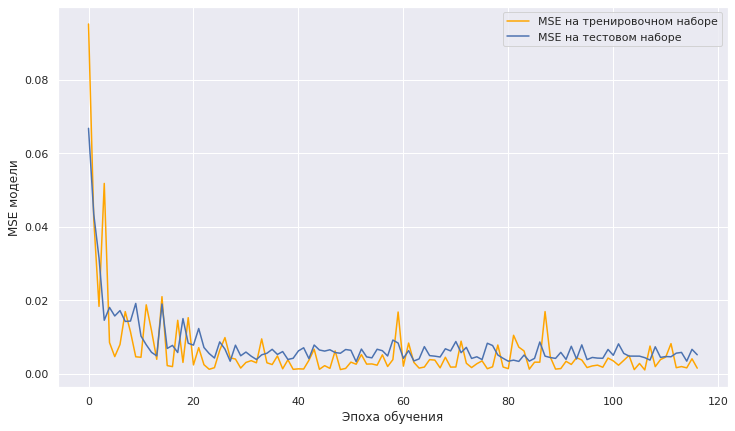

In [ ]:
# Постройте кривые обучения
# для longitude

plt.figure(figsize=(12, 7))
plt.plot(train_long_loss, 
         label='MSE на тренировочном наборе',
         color='orange')
plt.plot(test_long_loss, 
         label='MSE на тестовом наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE модели')
plt.legend()
plt.show()

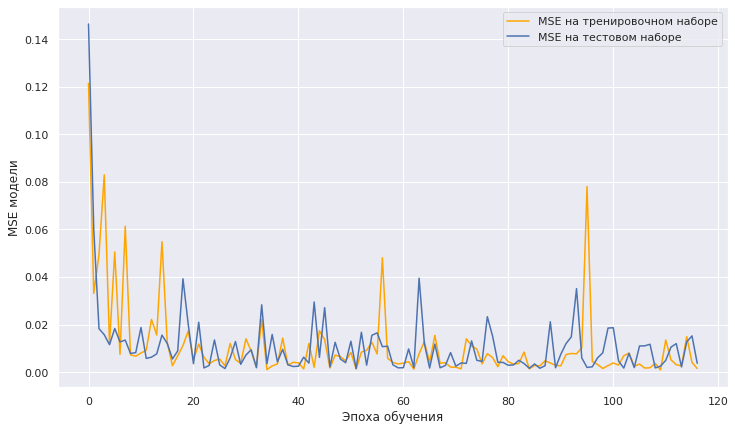

In [ ]:
# для latitude

plt.figure(figsize=(12, 7))
plt.plot(train_lat_loss, 
         label='MSE на тренировочном наборе',
         color='orange')
plt.plot(test_lat_loss, 
         label='MSE на тестовом наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE модели')
plt.legend()
plt.show()

In [ ]:
# предсказанные координаты

torch.cat([test_preds_long, test_preds_lat], dim=1)

tensor([[-8.6030, 41.2200],
        [-8.6002, 41.2233],
        [-8.5892, 41.2294],
        [-8.6050, 41.1591],
        [-8.6368, 41.2139],
        [-8.4586, 41.2475],
        [-8.5896, 41.1488],
        [-8.5597, 41.2452],
        [-8.6108, 41.1310],
        [-8.6080, 41.2420],
        [-8.5570, 41.2380],
        [-8.5555, 41.2241],
        [-8.5537, 41.2281],
        [-8.6303, 41.2000],
        [-8.5874, 41.2162],
        [-8.6178, 41.1563],
        [-8.6073, 41.1571],
        [-8.6360, 41.2193],
        [-8.5993, 41.4381],
        [-8.6366, 41.1351],
        [-8.5858, 41.2199],
        [-8.6036, 41.0407],
        [-8.6432, 41.2197],
        [-8.5928, 41.1089],
        [-8.6119, 41.2180],
        [-8.5666, 41.2545],
        [-8.6006, 41.1231],
        [-8.5762, 41.2202],
        [-8.6383, 41.3140],
        [-8.5972, 41.2272],
        [-8.5890, 41.2266],
        [-8.5768, 41.1677],
        [-8.5657, 41.1671],
        [-8.5817, 41.2146],
        [-8.6515, 41.2329],
        [-8.6815, 41